# Importing Libraries

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

# Information About Dataset

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T)

In [3]:
train = pd.read_csv("train.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])
sample_sub = pd.read_csv("sample_submission.csv")
df = pd.concat([train, test], sort=False)

In [4]:
print("##################### Train Dates #####################")
print(f'Minimum Date (train): {train["date"].min()}')
print(f'Maximum Date (train): {train["date"].max()}')
print("##################### Test Dates #####################")
print(f'Minimum Date (test): {test["date"].min()}')
print(f'Maximum Date (test): {test["date"].max()}')

##################### Train Dates #####################
Minimum Date (train): 2013-01-01 00:00:00
Maximum Date (train): 2017-12-31 00:00:00
##################### Test Dates #####################
Minimum Date (test): 2018-01-01 00:00:00
Maximum Date (test): 2018-03-31 00:00:00


In [5]:
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
##################### Tail ############

In [6]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB
None
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
##################### Tail #####################
          id      

In [7]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB
None
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01

In [8]:
# How many store we have?
df[["store"]].nunique()

store    10
dtype: int64

In [9]:
# How many item we have?
df[["item"]].nunique()

item    50
dtype: int64

In [10]:
# How many unique item in a store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [11]:
# store-item sales statistics
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

In [12]:
# store-item sales statistics
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

In [13]:
# Sales distribution among items within stores
df.groupby(["store", "item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
           count       sum       mean median        std   min    max
store item                                                          
1     1     1826   36468.0  19.971522   19.0   6.741022   4.0   50.0
      2     1826   97050.0  53.148959   52.0  15.005779  13.0  115.0
      3     1826   60638.0  33.208105   33.0  10.072529   8.0   70.0
      4     1826   36440.0  19.956188   20.0   6.640618   4.0   43.0
      5     1826   30335.0  16.612815   16.0   5.672102   3.0   37.0
...          ...       ...        ...    ...        ...   ...    ...
10    46    1826  120601.0  66.046550   65.0  18.114991  23.0  125.0
      47    1826   45204.0  24.755750   24.0   7.924820   6.0   56.0
      48    1826  105570.0  57.814896   57.0  15.898538  21.0  120.0
      49    1826   60317.0  33.032311   32.0  10.091610   6.0   69.0
      50    1826  135192.0  74.037240   73.0  19.937566  24.0  150.0

[500 rows x 7 columns]

# Feature Engineering

## Creating Date Features


In [14]:
def create_date_features(df):
    # dates
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    
    # days
    df['day_of_week'] = df.date.dt.dayofweek
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear 
    
    df['week_of_year'] = df.date.dt.weekofyear
    
    # quarter
    df["quarter"] = df.date.dt.quarter
    
    # weekend
    df["is_wknd"] = df.date.dt.weekday // 4
    
    # start - end
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) 
    
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    
    # season
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    #df["season"] = np.where(df.month.isin([3,4,5]), 1, df["season"])
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    
    
    return df

In [15]:
create_date_features(df)

,date,store,item,sales,id,year,month,day_of_week,day_of_month,day_of_year,week_of_year,quarter,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,1,1,0,1,0,1,0,1,0,0
1,2013-01-02,1,1,11.0,NaN,2013,1,2,2,2,1,1,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,14.0,NaN,2013,1,3,3,3,1,1,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,13.0,NaN,2013,1,4,4,4,1,1,1,0,0,0,0,0,0,0
4,2013-01-05,1,1,10.0,NaN,2013,1,5,5,5,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,27,86,13,1,0,0,0,0,0,0,0,1
44996,2018-03-28,10,50,NaN,44996.0,2018,3,2,28,87,13,1,0,0,0,0,0,0,0,1
44997,2018-03-29,10,50,NaN,44997.0,2018,3,3,29,88,13,1,0,0,0,0,0,0,0,1
44998,2018-03-30,10,50,NaN,44998.0,2018,3,4,30,89,13,1,1,0,0,0,0,0,0,1


## Random Noise

In [16]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

## Lag/Shifted Features

In [17]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [18]:
def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

In [19]:
lag_features(df, lags = [91, 92, 93, 94, 95, 96, 97, 98, 105, 112, 119, 126, 182, 364, 546, 728],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

,date,store,item,sales,id,year,month,day_of_week,day_of_month,day_of_year,...,sales_lag_97,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2013,1,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,2013,1,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,2013,1,4,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,2013,1,5,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,27,86,...,51.0,54.0,67.0,68.0,68.0,81.0,79.0,60.0,97.0,73.0
44996,2018-03-28,10,50,NaN,44996.0,2018,3,2,28,87,...,63.0,51.0,67.0,60.0,76.0,81.0,80.0,73.0,80.0,68.0
44997,2018-03-29,10,50,NaN,44997.0,2018,3,3,29,88,...,75.0,63.0,72.0,66.0,73.0,87.0,82.0,68.0,99.0,75.0
44998,2018-03-30,10,50,NaN,44998.0,2018,3,4,30,89,...,70.0,75.0,72.0,67.0,66.0,81.0,90.0,69.0,79.0,83.0


## Rolling Mean Features

In [20]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [21]:
roll_mean_features(df, [365, 546, 730])

,date,store,item,sales,id,year,month,day_of_week,day_of_month,day_of_year,...,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,...,1,0,1,0,1,0,0,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2013,1,2,2,2,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,2013,1,3,3,3,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,2013,1,4,4,4,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,2013,1,5,5,5,...,0,0,0,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,27,86,...,0,0,0,0,0,0,1,90.303463,84.266833,84.660448
44996,2018-03-28,10,50,NaN,44996.0,2018,3,2,28,87,...,0,0,0,0,0,0,1,86.941584,85.898547,81.868355
44997,2018-03-29,10,50,NaN,44997.0,2018,3,3,29,88,...,0,0,0,0,0,0,1,88.343357,86.311285,83.515827
44998,2018-03-30,10,50,NaN,44998.0,2018,3,4,30,89,...,0,0,0,0,0,0,1,86.876599,86.305001,81.384703


## Exponentially Weighted Mean Features

In [22]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [23]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 92, 93, 94, 95, 96, 97, 98, 105, 112, 119, 126, 182, 364, 546, 728]

ewm_features(df, alphas, lags)

,date,store,item,sales,id,year,month,day_of_week,day_of_month,day_of_year,...,sales_ewm_alpha_05_lag_97,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2013,1,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,2013,1,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,2013,1,4,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,2013,1,5,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,27,86,...,54.824351,58.648702,64.033868,64.335072,76.889157,78.812122,79.314746,65.867479,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,2018,3,2,28,87,...,58.912176,54.824351,65.516934,62.167536,76.444579,79.906061,79.657373,69.433740,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,2018,3,3,29,88,...,66.956088,58.912176,68.758467,64.083768,74.722289,83.453030,80.828687,68.716870,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,2018,3,4,30,89,...,68.478044,66.956088,70.379233,65.541884,70.361145,82.226515,85.414343,68.858435,84.936127,77.366739


In [24]:
df = create_date_features(df)
df = lag_features(df, lags = [91, 92, 93, 94, 95, 96, 97, 98, 105, 112, 119, 126, 182, 364, 546, 728],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')
df = roll_mean_features(df, [365, 546, 730])
df = ewm_features(df, alphas, lags)

In [25]:
df

,date,store,item,sales,id,year,month,day_of_week,day_of_month,day_of_year,...,sales_ewm_alpha_05_lag_97,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_119,sales_ewm_alpha_05_lag_126,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,2013,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2013,1,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,2013,1,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,2013,1,4,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,2013,1,5,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,2018,3,1,27,86,...,54.824351,58.648702,64.033868,64.335072,76.889157,78.812122,79.314746,65.867479,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,2018,3,2,28,87,...,58.912176,54.824351,65.516934,62.167536,76.444579,79.906061,79.657373,69.433740,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,2018,3,3,29,88,...,66.956088,58.912176,68.758467,64.083768,74.722289,83.453030,80.828687,68.716870,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,2018,3,4,30,89,...,68.478044,66.956088,70.379233,65.541884,70.361145,82.226515,85.414343,68.858435,84.936127,77.366739


In [26]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'day_of_month', 'month'])

In [27]:
df['sales'] = np.log1p(df["sales"].values)

In [28]:
df

,date,sales,id,year,day_of_year,week_of_year,quarter,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,2013,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2013,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,2013,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,2013,4,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,NaN,2013,5,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,NaN,44995.0,2018,86,13,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44996,2018-03-28,NaN,44996.0,2018,87,13,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44997,2018-03-29,NaN,44997.0,2018,88,13,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44998,2018-03-30,NaN,44998.0,2018,89,13,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0


# Train - Validation Split

In [29]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-07-01"), :]
validation = df.loc[(df["date"] >= "2017-07-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')


##################### Length #####################
Total # of sample in whole dataset: 913000
Total # of sample in train dataset: 821000
Total # of sample in validation dataset: 92000
##################### Shape #####################
Shape of train dataset: (821000, 220)
Shape of validation validation dataset: (92000, 220)
##################### Percantage #####################
Percentage of train dataset: 88.79%
Percentage of validation dataset: 11.21%


# Custom Cost Function (SMAPE)

In [30]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Model  #1

## Default Parameters


In [31]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(y_valid, first_model.predict(X_valid)))

TRAIN SMAPE: 3.62193211757785
VALID SMAPE: 3.1316172812271197


## Custom Parameters

In [32]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'n_estimators' : 15000,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': 20,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [33]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24593
[LightGBM] [Info] Number of data points in the train set: 821000, number of used features: 220
[LightGBM] [Info] Start training from score 3.801405
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.131864	training's SMAPE: 13.5259	valid_1's l1: 0.120378	valid_1's SMAPE: 12.286
[200]	training's l1: 0.128971	training's SMAPE: 13.2358	valid_1's l1: 0.11793	valid_1's SMAPE: 12.0398
[300]	training's l1: 0.127684	training's SMAPE: 13.106	valid_1's l1: 0.116931	valid_1's SMAPE: 11.9393
[400]	training's l1: 0.126928	training's SMAPE: 13.0296	valid_1's l1: 0.116286	valid_1's SMAPE: 11.8744
[500]	training's l1: 0.126441	training's SMAPE: 12.9803	valid_1's l1: 0.115861	valid_1's SMAPE: 11.8316
[600]	training's l1: 0.126057	training's SMAPE: 12.9415	valid_1's l1: 0.1

11.69732859843897

## Feature Importance

                         feature  split       gain
13           sales_roll_mean_730   1432  62.141723
91    sales_ewm_alpha_07_lag_364    664  10.940227
12           sales_roll_mean_546   1085   6.695191
107   sales_ewm_alpha_05_lag_364    870   6.037250
10                        season    307   3.623248
14                  sales_lag_91    300   2.261045
170                day_of_week_0    216   1.262961
3                        is_wknd    203   1.204964
29                 sales_lag_728    346   0.447900
0                    day_of_year    952   0.432242
21                  sales_lag_98    198   0.400615
1                   week_of_year    330   0.375423
109   sales_ewm_alpha_05_lag_728    417   0.341514
45   sales_ewm_alpha_095_lag_728    199   0.296229
11           sales_roll_mean_365    872   0.239530
2                        quarter    114   0.199296
30    sales_ewm_alpha_095_lag_91    173   0.189472
214                      month_7    127   0.186854
77    sales_ewm_alpha_08_lag_72

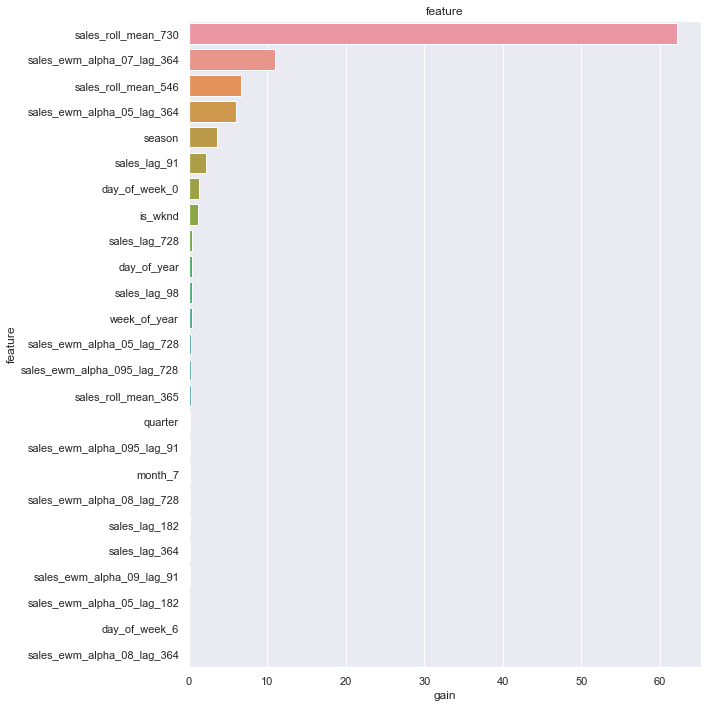

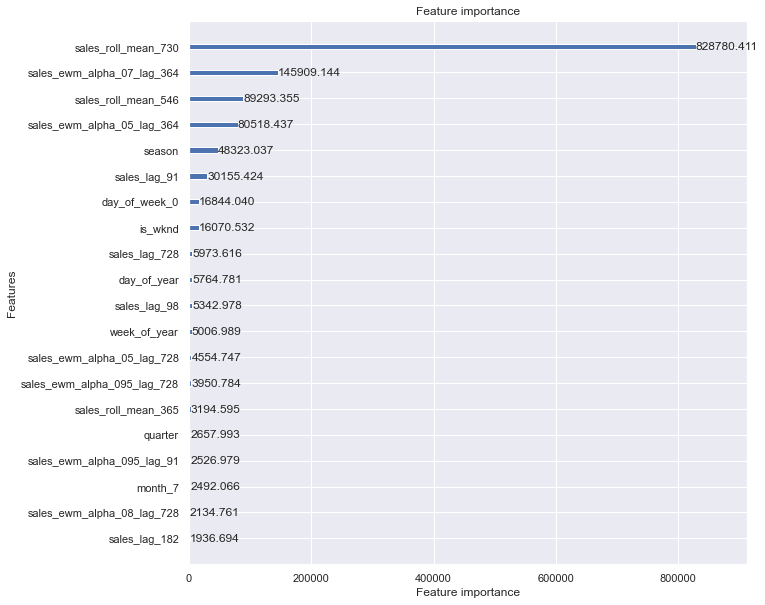

In [34]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

# Model #2

In [35]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-10-01"), :]
validation = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')


##################### Length #####################
Total # of sample in whole dataset: 913000
Total # of sample in train dataset: 867000
Total # of sample in validation dataset: 46000
##################### Shape #####################
Shape of train dataset: (867000, 220)
Shape of validation validation dataset: (46000, 220)
##################### Percantage #####################
Percentage of train dataset: 94.69%
Percentage of validation dataset: 5.31%


In [36]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'n_estimators' : 15000,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': 20,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [37]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.397258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24643
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 220
[LightGBM] [Info] Start training from score 3.817370
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.13096	training's SMAPE: 13.4285	valid_1's l1: 0.126404	valid_1's SMAPE: 12.9319
[200]	training's l1: 0.128118	training's SMAPE: 13.1436	valid_1's l1: 0.124132	valid_1's SMAPE: 12.7032
[300]	training's l1: 0.126824	training's SMAPE: 13.013	valid_1's l1: 0.123196	valid_1's SMAPE: 12.6088
[400]	training's l1: 0.126066	training's SMAPE: 12.9364	valid_1's l1: 0.122504	valid_1's SMAPE: 12.5391
[500]	training's l1: 0.125574	training's SMAPE: 12.8866	valid_1's l1: 0.122115	valid_1's SMAPE: 12.4999
[600]	training's l1: 0.125198	training's SMAPE: 12.8485	valid_1's l1: 0.

12.360326203591669

# Model #3

In [38]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-01-01"), :]
validation = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')


##################### Length #####################
Total # of sample in whole dataset: 775500
Total # of sample in train dataset: 730500
Total # of sample in validation dataset: 45000
##################### Shape #####################
Shape of train dataset: (730500, 220)
Shape of validation validation dataset: (45000, 220)
##################### Percantage #####################
Percentage of train dataset: 93.84%
Percentage of validation dataset: 6.16%


In [39]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'n_estimators' : 15000,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': 20,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [40]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24609
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 220
[LightGBM] [Info] Start training from score 3.789881
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.132397	training's SMAPE: 13.5852	valid_1's l1: 0.137677	valid_1's SMAPE: 14.1403
[200]	training's l1: 0.129398	training's SMAPE: 13.284	valid_1's l1: 0.134778	valid_1's SMAPE: 13.8487
[300]	training's l1: 0.12815	training's SMAPE: 13.1582	valid_1's l1: 0.133525	valid_1's SMAPE: 13.7224
[400]	training's l1: 0.12744	training's SMAPE: 13.0864	valid_1's l1: 0.132964	valid_1's SMAPE: 13.6657
[500]	training's l1: 0.126967	training's SMAPE: 13.0385	valid_1's l1: 0.132636	valid_1's SMAPE: 13.6327
[600]	training's l1: 0.126582	training's SMAPE: 12.9995	valid_1's l1: 0.1

13.5205481063729

# Model #4

In [41]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-07-01"), :]
validation = df.loc[(df["date"] >= "2017-07-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')

##################### Length #####################
Total # of sample in whole dataset: 913000
Total # of sample in train dataset: 821000
Total # of sample in validation dataset: 92000
##################### Shape #####################
Shape of train dataset: (821000, 220)
Shape of validation validation dataset: (92000, 220)
##################### Percantage #####################
Percentage of train dataset: 88.79%
Percentage of validation dataset: 11.21%


In [42]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 31,
              'n_estimators' : 100,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': -1,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [43]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24615
[LightGBM] [Info] Number of data points in the train set: 821000, number of used features: 220
[LightGBM] [Info] Start training from score 3.801405
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.128205	training's SMAPE: 13.1584	valid_1's l1: 0.11778	valid_1's SMAPE: 12.0242
[200]	training's l1: 0.126094	training's SMAPE: 12.9451	valid_1's l1: 0.116038	valid_1's SMAPE: 11.8492
[300]	training's l1: 0.125186	training's SMAPE: 12.8528	valid_1's l1: 0.115573	valid_1's SMAPE: 11.8025
[400]	training's l1: 0.124489	training's SMAPE: 12.7817	valid_1's l1: 0.115329	valid_1's SMAPE: 11.778
[500]	training's l1: 0.123879	training's SMAPE: 12.7193	valid_1's l1: 0.115187	valid_1's SMAPE: 11.7638
[600]	training's l1: 0.12332	training's SMAPE: 12.6623	valid_1's l1: 0.1

11.740519707934508

# Model 5#

In [44]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-10-01"), :]
validation = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')

##################### Length #####################
Total # of sample in whole dataset: 913000
Total # of sample in train dataset: 867000
Total # of sample in validation dataset: 46000
##################### Shape #####################
Shape of train dataset: (867000, 220)
Shape of validation validation dataset: (46000, 220)
##################### Percantage #####################
Percentage of train dataset: 94.69%
Percentage of validation dataset: 5.31%


In [45]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 31,
              'n_estimators' : 100,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': -1,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [46]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.464299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24640
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 220
[LightGBM] [Info] Start training from score 3.817370
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.127317	training's SMAPE: 13.0625	valid_1's l1: 0.12403	valid_1's SMAPE: 12.6928
[200]	training's l1: 0.125203	training's SMAPE: 12.849	valid_1's l1: 0.122435	valid_1's SMAPE: 12.5324
[300]	training's l1: 0.124301	training's SMAPE: 12.7574	valid_1's l1: 0.121967	valid_1's SMAPE: 12.4854
[400]	training's l1: 0.123634	training's SMAPE: 12.6895	valid_1's l1: 0.121728	valid_1's SMAPE: 12.4612
[500]	training's l1: 0.123041	training's SMAPE: 12.6289	valid_1's l1: 0.121586	valid_1's SMAPE: 12.4471
[600]	training's l1: 0.122511	training's SMAPE: 12.5746	valid_1's l1: 0.

12.422223647392075

# Model #6

In [47]:
# Dataframe must be sorted by date because of Time Series Split 
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-01-01"), :]
validation = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

X_train = train[cols]
y_train = train['sales']

X_valid = validation[cols]
y_valid = validation['sales']

print("##################### Length #####################")
print(f'Total # of sample in whole dataset: {len(train)+len(validation)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_valid)}')

print("##################### Shape #####################")
print(f'Shape of train dataset: {X_train.shape}')
print(f'Shape of validation validation dataset: {X_valid.shape}')

print("##################### Percantage #####################")
print(f'Percentage of train dataset: {round(100-((len(validation)/len(train))*100),2)}%')
print(f'Percentage of validation dataset: {round(((len(validation)/len(train))*100),2)}%')

##################### Length #####################
Total # of sample in whole dataset: 775500
Total # of sample in train dataset: 730500
Total # of sample in validation dataset: 45000
##################### Shape #####################
Shape of train dataset: (730500, 220)
Shape of validation validation dataset: (45000, 220)
##################### Percantage #####################
Percentage of train dataset: 93.84%
Percentage of validation dataset: 6.16%


In [48]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 31,
              'n_estimators' : 100,
              'learning_rate': 0.1,
              'feature_fraction': 1.0,
              'max_depth': -1,
              'random_state' : 384,
              'verbose': 1,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [49]:
lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_valid, label=y_valid, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_valid, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(y_valid))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.372313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24592
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 220
[LightGBM] [Info] Start training from score 3.789881
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.128721	training's SMAPE: 13.2154	valid_1's l1: 0.134738	valid_1's SMAPE: 13.8447
[200]	training's l1: 0.126631	training's SMAPE: 13.0042	valid_1's l1: 0.132888	valid_1's SMAPE: 13.6583
[300]	training's l1: 0.125674	training's SMAPE: 12.907	valid_1's l1: 0.132462	valid_1's SMAPE: 13.616
[400]	training's l1: 0.124947	training's SMAPE: 12.8327	valid_1's l1: 0.132334	valid_1's SMAPE: 13.6031
[500]	training's l1: 0.124285	training's SMAPE: 12.765	valid_1's l1: 0.132216	valid_1's SMAPE: 13.5914
[600]	training's l1: 0.123672	training's SMAPE: 12.7023	valid_1's l1: 0.1

13.575977133300844

# Parameter Sets for LightGBM

<table>
  <tbody><tr>
    <th>Parameters</th>
    <th>Parameter Set #1</th>
    <th>Parameter Set #2</th>
  </tr>      
  <tr>
    <td>metric</td>
    <td>mae</td>
    <td>mae</td>
  </tr>
  <tr>
    <td>num_leaves</td>
    <td>10</td>
    <td>31</td>
  </tr>
  <tr>
    <td>n_estimators</td>
    <td>15000</td>
    <td>100</td>
  </tr> 
  <tr>
    <td>learning_rate</td>
    <td>0.1</td>
    <td>0.1</td>
  </tr> 
  <tr>
    <td>feature_fraction</td>
    <td>1.0</td>
    <td>1.0</td>
  </tr> 
  <tr>
    <td>max_depth</td>
    <td>20</td>
    <td>-1</td>
  </tr> 
  <tr>
    <td>random_state</td>
    <td>384</td>
    <td>384</td>
  </tr> 
  <tr>
    <td>verbose</td>
    <td>1</td>
    <td>1</td>
  </tr> 
  <tr>
    <td>num_boost_round</td>
    <td>10000</td>
    <td>10000</td>
  </tr> 
  <tr>
    <td>early_stopping_rounds</td>
    <td>200</td>
    <td>200</td>
  </tr> 
  <tr>
    <td>nthread</td>
    <td>-1</td>
    <td>-1</td>
  </tr>     
      
</tbody></table>

# RESULTS

<table>
  <tbody><tr>
    <th>MODEL #</th>
    <th>Train - Validation %</th>
    <th>Date Interval Train</th>
    <th>Date Interval Validation</th>
    <th># of Samples in Train Dataset</th>
    <th># of Samples in Validation Dataset</th>
    <th># of Samples in Dataset</th>
    <th>Parameter Set #</th>
    <th>SMAPE</th>
  </tr>
  <tr>
    <td>Model #1</td>
    <td>88% - 12%</td>
    <td>01/01/2013 - 01/07/2017</td>
    <td>01/07/2017 - 01/01/2018</td>
    <td>821.000</td>
    <td>92.000</td>
    <td>913.000</td>
    <th>#1</th>
    <th>11.7</th>  
  </tr>
  <tr>
    <td>Model #2</td>
    <td>95% - 5%</td>
    <td>01/01/2013 - 01/10/2017</td>
    <td>01/10/2017 - 01/01/2018</td>
    <td>867.000</td>
    <td>46.000</td>
    <td>913.000</td>
    <th>#1</th>
    <th>12.4</th>  
  </tr>
  <tr>
    <td>Model #3</td>
    <td>94% - 6%</td>
    <td>01/01/2013 - 01/01/2017</td>
    <td>01/01/2017 - 01/04/2017</td>
    <td>730.500</td>
    <td>45.000</td>
    <td>775.500</td>
    <th>#1</th>
    <th>13.5</th>  
  </tr>
      
  <tr>
    <td>Model #4</td>
    <td>88% - 12%</td>
    <td>01/01/2013 - 01/07/2017</td>
    <td>01/07/2017 - 01/01/2018</td>
    <td>821.000</td>
    <td>92.000</td>
    <td>913.000</td>
    <th>#2</th>
    <th>11.7</th>   
  </tr>
  <tr>
    <td>Model #5</td>
    <td>95% - 5%</td>
    <td>01/01/2013 - 01/10/2017</td>
    <td>01/10/2017 - 01/01/2018</td>
    <td>867.000</td>
    <td>46.000</td>
    <td>913.000</td>
    <th>#2</th>
    <th>12.4</th> 
  </tr>
  <tr>
    <td>Model #6</td>
    <td>94% - 6%</td>
    <td>01/01/2013 - 01/01/2017</td>
    <td>01/01/2017 - 01/04/2017</td>
    <td>730.500</td>
    <td>45.000</td>
    <td>775.500</td>
    <th>#2</th>
    <th>13.5</th>  
  </tr>
      
  
</tbody></table>